In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [3]:
import os
import pickle
import re




In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV,RandomizedSearchCV
from sklearn.metrics import precision_score,f1_score,recall_score,classification_report,accuracy_score
import joblib
from imblearn.over_sampling import SMOTE
from tqdm import tqdm

In [5]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [6]:
file_path = '/content/drive/My Drive/FolderName/new_train_sample.csv'


In [7]:
!ls /content/drive/My\ Drive


'Colab Notebooks'		  'Hacker Rank Complete Problems with Solution.gdoc'
'Copy of Copy of itp_day2.ipynb'   new_train_sample.csv


In [8]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [9]:
from google.colab import drive
drive.mount('/content/drive')

# Verify folder structure
!ls /content/drive/My\ Drive

# Correct path to your file
file_path = '/content/drive/My Drive/FolderName/new_train_sample.csv'

# Read the CSV
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/new_train_sample.csv')
print(df.head())


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
'Colab Notebooks'		  'Hacker Rank Complete Problems with Solution.gdoc'
'Copy of Copy of itp_day2.ipynb'   new_train_sample.csv
   Unnamed: 0             Id  OrgId  IncidentId  AlertId  \
0     5172780  1709396985476     26       18583   687462   
1     8470561   927712939180     33        5065     3990   
2     5897583  1090921697002    201      150787   807590   
3     3288552  1434519079555    204      108287    28575   
4     4060961  1005022347708     54      528202  1458226   

                  Timestamp  DetectorId  AlertTitle            Category  \
0  2024-06-06T05:56:47.000Z          31         813             Malware   
1  2024-06-03T10:45:09.000Z          38          25              Impact   
2  2024-06-13T03:36:40.000Z         419         444           Execution   
3  2024-06-08T16:54:57.000Z          44        1233  SuspiciousActivity   
4  2024

In [10]:
df.isnull().sum()

,0
Unnamed: 0,0
Id,0
OrgId,0
IncidentId,0
AlertId,0
Timestamp,0
DetectorId,0
AlertTitle,0
Category,0
MitreTechniques,2733136


In [11]:
threshold = len(df) * 0.5
df.dropna(axis=1, thresh=threshold,inplace=True)

print(df.nunique())
# Discard columns that contain only a single unique value.
df = df.loc[:, df.nunique() > 1]

# Checking for duplicate rows and drop those rows
print(df.duplicated().sum())
df.drop_duplicates(keep='first',inplace=True)
print(df.duplicated().sum())

Unnamed: 0            4758418
Id                     657035
OrgId                    5607
IncidentId             432289
AlertId               1163873
Timestamp              723647
DetectorId               7908
AlertTitle              80121
Category                   20
IncidentGrade               3
EntityType                 31
EvidenceRole                2
DeviceId                55410
Sha256                  73078
IpAddress              195384
Url                     85332
AccountSid             270273
AccountUpn             398767
AccountObjectId        262205
AccountName            276656
DeviceName              81164
NetworkMessageId       260032
RegistryKey               937
RegistryValueName         401
RegistryValueData         496
ApplicationId            1003
ApplicationName          1610
OAuthApplicationId        416
FileName               142641
FolderPath              59652
ResourceIdName           1516
OSFamily                    6
OSVersion                  48
CountryCod

In [12]:
# Inspect columns
print("Columns in the dataframe:", df.columns.tolist())

# Drop only existing columns
columns_to_drop = ['Unnamed: 0', 'IncidentId', 'AlertId', 'Id', 'AccountUpn', 'OSVersion',
                   'EmailClusterId', 'NetworkMessageId', 'AccountObjectId', 'DeviceName',
                   'Sha256', 'OSFamily', 'FolderPath', 'FileName', 'OAuthApplicationId',
                   'ApplicationName', 'ApplicationId', 'RegistryValueData','State','AccountName'
                   'RegistryValueName', 'RegistryKey']

df.drop(columns=[col for col in columns_to_drop if col in df.columns], inplace=True)

# Verify remaining columns
print("Remaining columns:", df.columns.tolist())


Columns in the dataframe: ['Unnamed: 0', 'Id', 'OrgId', 'IncidentId', 'AlertId', 'Timestamp', 'DetectorId', 'AlertTitle', 'Category', 'IncidentGrade', 'EntityType', 'EvidenceRole', 'DeviceId', 'Sha256', 'IpAddress', 'Url', 'AccountSid', 'AccountUpn', 'AccountObjectId', 'AccountName', 'DeviceName', 'NetworkMessageId', 'RegistryKey', 'RegistryValueName', 'RegistryValueData', 'ApplicationId', 'ApplicationName', 'OAuthApplicationId', 'FileName', 'FolderPath', 'ResourceIdName', 'OSFamily', 'OSVersion', 'CountryCode', 'State', 'City']
Remaining columns: ['OrgId', 'Timestamp', 'DetectorId', 'AlertTitle', 'Category', 'IncidentGrade', 'EntityType', 'EvidenceRole', 'DeviceId', 'IpAddress', 'Url', 'AccountSid', 'AccountName', 'RegistryValueName', 'ResourceIdName', 'CountryCode', 'City']


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4758418 entries, 0 to 4758417
Data columns (total 17 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   OrgId              int64 
 1   Timestamp          object
 2   DetectorId         int64 
 3   AlertTitle         int64 
 4   Category           object
 5   IncidentGrade      object
 6   EntityType         object
 7   EvidenceRole       object
 8   DeviceId           int64 
 9   IpAddress          int64 
 10  Url                int64 
 11  AccountSid         int64 
 12  AccountName        int64 
 13  RegistryValueName  int64 
 14  ResourceIdName     int64 
 15  CountryCode        int64 
 16  City               int64 
dtypes: int64(12), object(5)
memory usage: 617.2+ MB


In [14]:
df.isnull().sum()

,0
OrgId,0
Timestamp,0
DetectorId,0
AlertTitle,0
Category,0
IncidentGrade,25775
EntityType,0
EvidenceRole,0
DeviceId,0
IpAddress,0


In [15]:
# Fill null values in 'IncidentGrade' with the previous (forward fill) values
df['IncidentGrade'] = df['IncidentGrade'].fillna(method='ffill')

In [16]:
import pandas as pd

# Ensure Timestamp column is split into Date and Time
df[['Date', 'Time']] = df['Timestamp'].str.replace('T', ' ', regex=False).str.replace('.000Z', '', regex=False).str.split(' ', expand=True)

# Drop the original Timestamp column if no longer needed
df.drop('Timestamp', axis=1, inplace=True)

# Display the updated dataframe
print(df.head())


   OrgId  DetectorId  AlertTitle            Category   IncidentGrade  \
0     26          31         813             Malware  BenignPositive   
1     33          38          25              Impact  BenignPositive   
2    201         419         444           Execution  BenignPositive   
3    204          44        1233  SuspiciousActivity    TruePositive   
4     54         102       58829        Exfiltration  BenignPositive   

  EntityType EvidenceRole  DeviceId  IpAddress     Url  AccountSid  \
0       File      Related     98799     360606  160396      441377   
1    Machine     Impacted     98799     360606  160396      441377   
2    Machine     Impacted     98799     360606  160396      441377   
3       File      Related     98799     360606  160396      441377   
4       File     Impacted     98799     360606  160396      441377   

   AccountName  RegistryValueName  ResourceIdName  CountryCode   City  \
0       453297                635            3586          242  10630   


In [17]:
# Extract the 'IncidentGrade' column into df2
df2 = df[['IncidentGrade']]

# Drop the 'IncidentGrade' column from the original df
df = df.drop(columns=['IncidentGrade'])

# Display the updated DataFrames
print("DataFrame df2:")
print(df2)

print("\nUpdated DataFrame df:")
print(df)


DataFrame df2:
          IncidentGrade
0        BenignPositive
1        BenignPositive
2        BenignPositive
3          TruePositive
4        BenignPositive
...                 ...
4758413   FalsePositive
4758414   FalsePositive
4758415  BenignPositive
4758416  BenignPositive
4758417  BenignPositive

[4758418 rows x 1 columns]

Updated DataFrame df:
         OrgId  DetectorId  AlertTitle            Category        EntityType  \
0           26          31         813             Malware              File   
1           33          38          25              Impact           Machine   
2          201         419         444           Execution           Machine   
3          204          44        1233  SuspiciousActivity              File   
4           54         102       58829        Exfiltration              File   
...        ...         ...         ...                 ...               ...   
4758413    142         112        7836        Exfiltration       MailMessage   
475841

In [18]:
# Get unique values in 'IncidentGrade' for df2 this is target table
unique_incident_grades = df2['IncidentGrade'].unique()
print("Unique values in IncidentGrade:")
print(unique_incident_grades)

# Get value counts for 'IncidentGrade' in df2
incident_grade_counts = df2['IncidentGrade'].value_counts()
print("\nValue counts for IncidentGrade:")
print(incident_grade_counts)


Unique values in IncidentGrade:
['BenignPositive' 'TruePositive' 'FalsePositive']

Value counts for IncidentGrade:
IncidentGrade
BenignPositive    2065863
TruePositive      1671302
FalsePositive     1021253
Name: count, dtype: int64


Correlations with IncidentGrade:
IncidentGrade        1.000000
OrgId                0.110589
Url                  0.083952
DeviceId             0.057959
ResourceIdName       0.016520
Category             0.012928
Date                 0.011983
RegistryValueName    0.002948
AccountName         -0.003284
AccountSid          -0.017644
Time                -0.018450
DetectorId          -0.053196
AlertTitle          -0.054142
EvidenceRole        -0.070597
IpAddress           -0.071431
EntityType          -0.072916
City                -0.120374
CountryCode         -0.131870
Name: IncidentGrade, dtype: float64


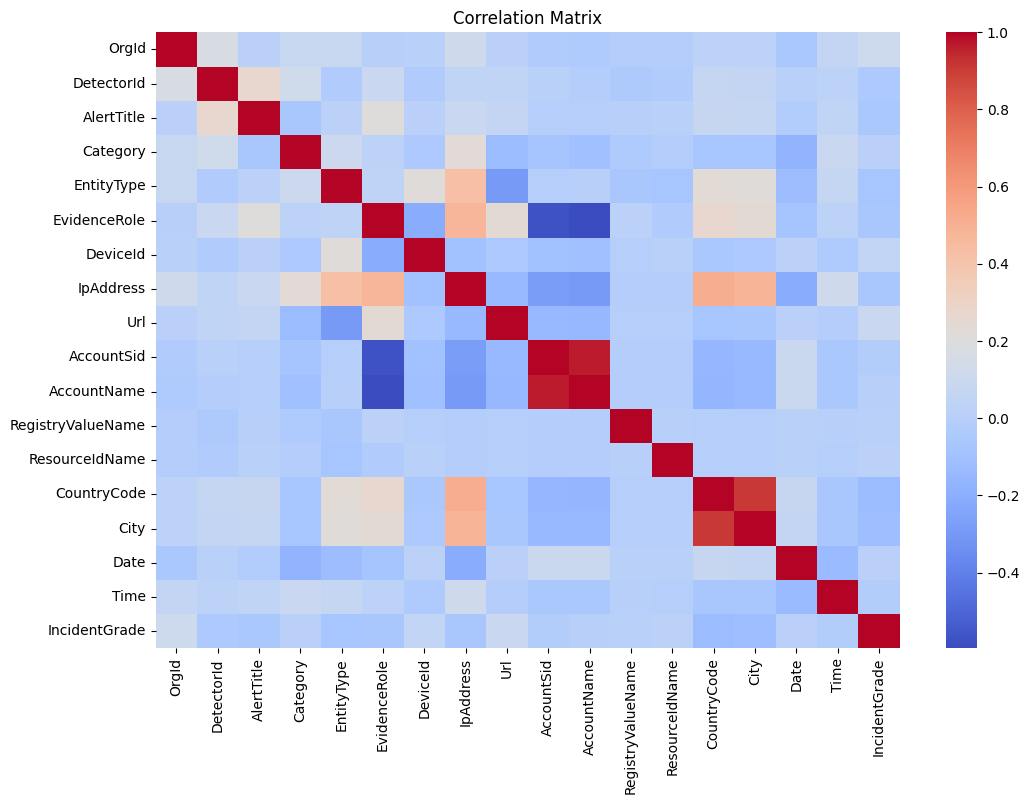

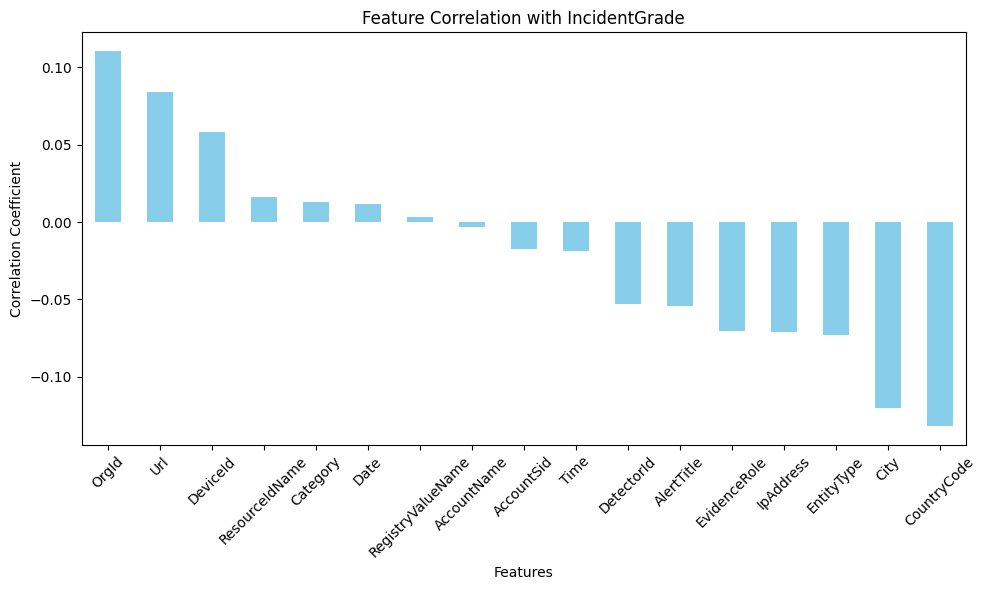

In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure the two DataFrames have the same length
if len(df) != len(df2):
    raise ValueError("The feature DataFrame (df) and target DataFrame (df2) must have the same number of rows.")

# Add the target column to the feature DataFrame
df['IncidentGrade'] = pd.factorize(df2['IncidentGrade'])[0]

# Convert non-numeric columns in df to numeric using one-hot encoding or factorization
for col in df.select_dtypes(include=['object']).columns:
    df[col] = pd.factorize(df[col])[0]

# Calculate the correlation matrix
correlation_matrix = df.corr()

# Extract correlations with the target 'IncidentGrade'
target_correlations = correlation_matrix['IncidentGrade'].sort_values(ascending=False)

# Display the correlations with the target
print("Correlations with IncidentGrade:")
print(target_correlations)

# Plot heatmap for all correlations
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title('Correlation Matrix')
plt.show()

# Plot bar chart for correlation with target
plt.figure(figsize=(10, 6))
target_correlations.drop('IncidentGrade').plot(kind='bar', color='skyblue')
plt.title('Feature Correlation with IncidentGrade')
plt.ylabel('Correlation Coefficient')
plt.xlabel('Features')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


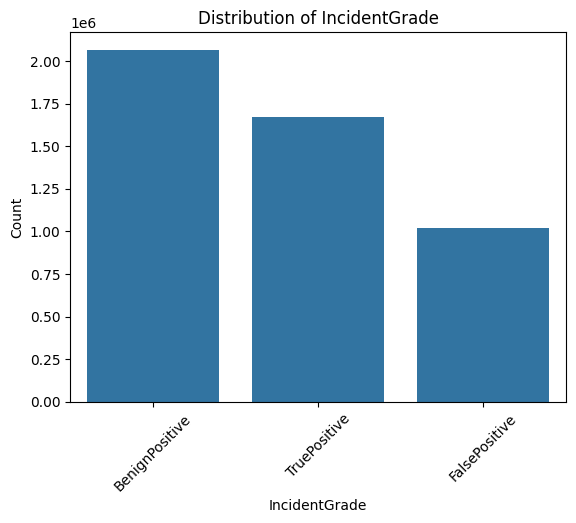

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# Distribution of the target variable
sns.countplot(x="IncidentGrade", data=df2)  # Use 'x' to specify the column name
plt.title("Distribution of IncidentGrade")
plt.xlabel("IncidentGrade")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


In [1]:
from sklearn.ensemble import RandomForestClassifier

In [22]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Step 1: Prepare the data
# Assume `df` contains the features and `df2` contains the target
df['IncidentGrade'] = pd.factorize(df2['IncidentGrade'])[0]  # Convert target to numeric

# Separate features and target
X = df.drop(columns=['IncidentGrade'])  # Features
y = df['IncidentGrade']  # Target

# Convert non-numeric columns to numeric using one-hot encoding or factorization
for col in X.select_dtypes(include=['object']).columns:
    X[col] = pd.factorize(X[col])[0]

# Step 2: Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 3: Train the RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Step 4: Make predictions
y_pred = clf.predict(X_test)

# Step 5: Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))

# Step 6: Feature importance (optional)
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': clf.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)


Confusion Matrix:
[[605330   7616   6819]
 [ 11960 481879   7468]
 [ 10770   7547 288137]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97    619765
           1       0.97      0.96      0.97    501307
           2       0.95      0.94      0.95    306454

    accuracy                           0.96   1427526
   macro avg       0.96      0.96      0.96   1427526
weighted avg       0.96      0.96      0.96   1427526


Accuracy Score:
0.9634472506980608

Feature Importance:
              Feature  Importance
0               OrgId    0.405918
1          DetectorId    0.148744
2          AlertTitle    0.113894
16               Time    0.079733
15               Date    0.053315
3            Category    0.039451
9          AccountSid    0.033474
10        AccountName    0.027003
7           IpAddress    0.024124
4          EntityType    0.023022
13        CountryCode    0.017404
8                 Url    0.010852
14   